In [3]:
import json
import yaml
import matplotlib.pyplot as plt
import pandas as pd

metrics = ["NDCG@k", "MAP@k", "Recall@k", "Precision@k", "MRR@k", "R_cap@k", "Hole@k", "Accuracy@k"]
datasets = ['nfcorpus','nq','hotpotqa','fiqa', 'webis-touche2020','dbpedia-entity','scidocs','fever','climate-fever','scifact']

def get_important_metrics(metrics: list):
    important_metrics = []
    for metric in metrics:
        if metric == "Precision@k":
            for k in [1,3,5,10]:
                important_metrics.append(f'P@{str(k)}')
        elif metric[:4] != 'Hole':
            for k in [1,3,5,10]:
                important_metrics.append(metric.replace('k',str(k)))
    return important_metrics
important_metrics = get_important_metrics(metrics)

def load_results(dataset: str):
    cfg = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)['chunker_config']
    results = [{'chunker': item[0]} | {'hyperparams': item[1]} for item in cfg]
    with open(f"results/new_eval_results_{dataset}.jsonl",'r') as f:
        for i, line in enumerate(f):
            result = json.loads(line)
            results[i].update(result)
    return results

def get_results_df(results: list):
    new_results = {}
    for item in results:
        temp = {}
        for metric in metrics:
            temp.update(item[metric])
        temp.update({'Latency': item['Latency']})
        key = item['chunker'] + '_' + '_'.join([k+'_'+str(v) for k,v in item['hyperparams'].items()])
        new_results[key] = temp
    return pd.DataFrame(new_results).T

def get_average_results():
    dfs = [get_results_df(load_results(dataset)) for dataset in datasets]
    return pd.concat(dfs).groupby(level=0).mean()

def get_best_config_per_chunker(df, keyword):
    idxs = [idx for idx in df.index if keyword in idx]
    df_sub = df.loc[idxs,important_metrics]
    return df_sub.index[df_sub.mean(axis=1).argmax()]

def get_hyperparam_comparison(df, hyperparam, default_method = None, exclude_methods = []):
    idxs = [idx for idx in df.index if hyperparam in idx or (default_method and idx == default_method)]
    if exclude_methods: idxs = [idx for idx in idxs if idx not in exclude_methods]
    return df.loc[idxs, important_metrics].sort_index()

def plot_metrics_cross_all_k(df, xargs = ['0', '0.25', '0.5', '0.75'], xlabel = 'lamda'):
    plot_metrics = ["NDCG", "MAP", "Recall", "P", "MRR", "R_cap", "Accuracy"]
    xticks = range(1,len(xargs)+1)
    for plot_metric in plot_metrics:
        cols = [column for column in df.columns if plot_metric in column]
        plt.plot(xticks, df[cols].mean(axis=1).tolist(), label=plot_metric)
    plt.xticks(xticks, xargs)
    # plt.yticks(yticks, yticks)
    plt.xlabel(xlabel)
    plt.ylabel('score')
    plt.legend()
    plt.show()

# Method Comparison

In [4]:
get_average_results()

,NDCG@1,NDCG@3,NDCG@5,NDCG@10,NDCG@100,NDCG@1000,MAP@1,MAP@3,MAP@5,MAP@10,...,Hole@10,Hole@100,Hole@1000,Accuracy@1,Accuracy@3,Accuracy@5,Accuracy@10,Accuracy@100,Accuracy@1000,Latency
cluster_chunker_mode_k-preserve,0.597240,0.567169,0.571127,0.581268,0.639435,0.681627,0.315137,0.399951,0.425175,0.453704,...,0.028409,0.035782,0.028503,0.616713,0.753132,0.804339,0.861850,0.976500,0.999440,17.459403
cluster_chunker_mode_k-preserve_lamda_0.25,0.599045,0.564414,0.566291,0.578004,0.636933,0.680789,0.315254,0.399589,0.423649,0.452661,...,0.028334,0.035691,0.028671,0.616193,0.742983,0.797317,0.859557,0.977420,0.999440,17.328200
cluster_chunker_mode_k-preserve_lamda_0.5,0.597240,0.567169,0.571127,0.581268,0.639435,0.681627,0.315137,0.399951,0.425175,0.453704,...,0.028409,0.035782,0.028503,0.616713,0.753132,0.804339,0.861850,0.976500,0.999440,17.448854
cluster_chunker_mode_k-preserve_lamda_0.75,0.593497,0.563913,0.571724,0.582069,0.641329,0.683650,0.315392,0.400264,0.426401,0.454762,...,0.028366,0.035980,0.028158,0.612354,0.751118,0.804313,0.864119,0.980298,0.999500,17.703449
cluster_chunker_mode_k-preserve_min_samples_2,0.644812,0.629496,0.635686,0.648439,0.711883,0.740811,0.359473,0.463072,0.490829,0.523779,...,0.026449,0.035801,0.023176,0.664016,0.810979,0.856778,0.907059,0.988616,0.999440,23.074685
cluster_chunker_mode_k-preserve_min_samples_4,0.641744,0.619176,0.622765,0.637891,0.697861,0.730086,0.353666,0.449101,0.476283,0.510914,...,0.026518,0.035605,0.025804,0.662029,0.803891,0.850409,0.899649,0.987916,0.999500,22.293953
cluster_chunker_mode_k-preserve_min_samples_6,0.619826,0.594949,0.600250,0.613065,0.672486,0.707875,0.333317,0.422328,0.450028,0.483410,...,0.028625,0.035745,0.027415,0.637745,0.786150,0.834125,0.886192,0.985575,0.999000,21.439873
cluster_chunker_mode_k-split_n_clusters_10,0.594720,0.564568,0.568714,0.577606,0.635340,0.685397,0.335601,0.422311,0.443464,0.463853,...,0.029818,0.037277,0.028425,0.614180,0.764687,0.818266,0.871652,0.977458,0.999000,17.355877
cluster_chunker_mode_k-split_n_clusters_20,0.617918,0.601418,0.604749,0.618664,0.678106,0.719253,0.356533,0.455183,0.478205,0.502785,...,0.028284,0.037909,0.025867,0.636568,0.797135,0.844574,0.896886,0.986637,0.999750,21.352656
cluster_chunker_mode_k-split_n_clusters_5,0.482625,0.453084,0.451400,0.459279,0.521489,0.582879,0.254224,0.318391,0.333723,0.351408,...,0.030756,0.036577,0.029349,0.501844,0.645292,0.701832,0.764439,0.960370,0.998600,14.291627


In [5]:
def get_method_comparison():
    df = get_average_results()
    best_k_preserve_idx = get_best_config_per_chunker(df, 'k-preserve')
    best_k_split_idx = get_best_config_per_chunker(df, 'k-split')
    best_sentence_idx = get_best_config_per_chunker(df, 'sentence')
    best_whole_idx = get_best_config_per_chunker(df, 'whole')
    best_word_idx = get_best_config_per_chunker(df, 'word')
    return df.loc[[best_k_preserve_idx, best_k_split_idx, best_sentence_idx, best_whole_idx, best_word_idx],important_metrics+['Latency']]

get_method_comparison()

,NDCG@1,NDCG@3,NDCG@5,NDCG@10,MAP@1,MAP@3,MAP@5,MAP@10,Recall@1,Recall@3,...,MRR@10,R_cap@1,R_cap@3,R_cap@5,R_cap@10,Accuracy@1,Accuracy@3,Accuracy@5,Accuracy@10,Latency
cluster_chunker_mode_k-preserve_min_samples_2,0.644812,0.629496,0.635686,0.648439,0.359473,0.463072,0.490829,0.523779,0.359473,0.496576,...,0.748588,0.664016,0.650610,0.663725,0.695171,0.664016,0.810979,0.856778,0.907059,23.074685
cluster_chunker_mode_k-split_n_clusters_20,0.617918,0.601418,0.604749,0.618664,0.356533,0.455183,0.478205,0.502785,0.356533,0.487784,...,0.726839,0.636568,0.620049,0.630211,0.660637,0.636568,0.797135,0.844574,0.896886,21.352656
sentence_chunker_k_3,0.649538,0.633780,0.636487,0.647541,0.358454,0.460424,0.487444,0.521125,0.358454,0.494065,...,0.750173,0.668353,0.653142,0.660711,0.690333,0.668353,0.812829,0.855625,0.903409,21.276099
whole_chunker_,0.281372,0.253246,0.247174,0.245018,0.111996,0.142749,0.152114,0.161680,0.111996,0.163967,...,0.369327,0.296750,0.265533,0.261224,0.271837,0.296750,0.419319,0.462521,0.530802,6.068957
word_chunker_k_10,0.577914,0.568000,0.575407,0.594533,0.326529,0.415421,0.440391,0.471475,0.326529,0.454343,...,0.694843,0.600128,0.591805,0.609559,0.650829,0.600128,0.765407,0.813696,0.879621,36.336027


# Hyperparameter Comparison

## lamda

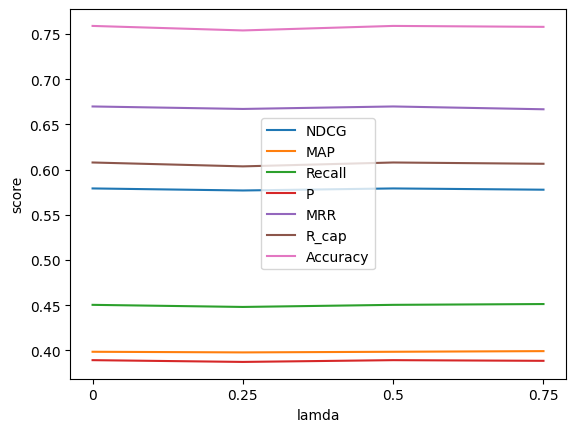

In [6]:
df = get_average_results()
df = get_hyperparam_comparison(df, 'lamda', 'cluster_chunker_mode_k-preserve')
plot_metrics_cross_all_k(df, xargs = ['0', '0.25', '0.5', '0.75'], xlabel = 'lamda')

## min_samples

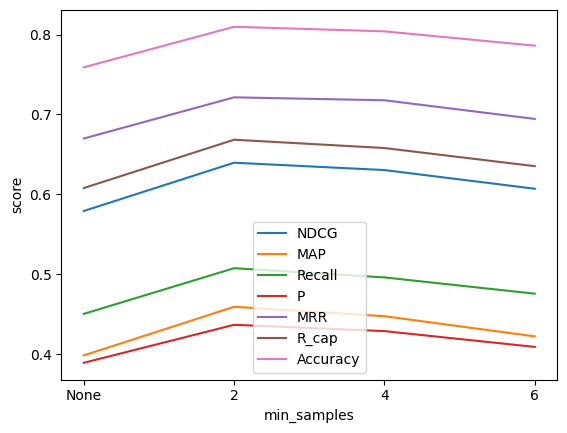

In [7]:
df = get_average_results()
df = get_hyperparam_comparison(df, 'min_samples', 'cluster_chunker_mode_k-preserve')
plot_metrics_cross_all_k(df, xargs = ['None', '2', '4', '6'], xlabel = 'min_samples')

## n_clusters

The configs I use are not representative, considering that each long document consists of 8 short documents.

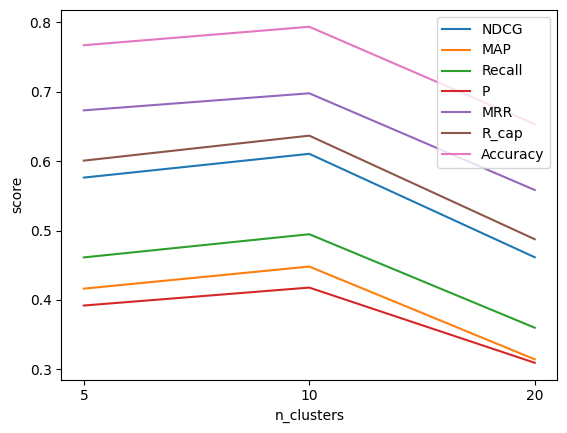

In [9]:
df = get_average_results()
df = get_hyperparam_comparison(df, 'n_clusters', exclude_methods=['cluster_chunker_mode_k-split_n_clusters_5_n_sents_per_segment_3', 'cluster_chunker_mode_k-split_n_clusters_5_n_sents_per_segment_5'])
plot_metrics_cross_all_k(df, xargs = ['5', '10', '20'], xlabel = 'n_clusters')

## n_sents_per_segment

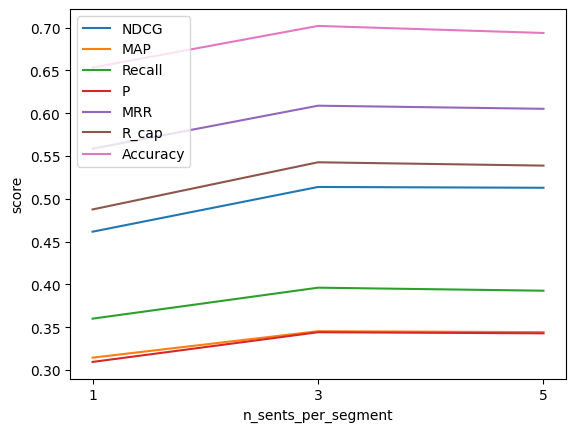

In [11]:
df = get_average_results()
df = get_hyperparam_comparison(df, 'n_sents_per_segment', default_method='cluster_chunker_mode_k-split_n_clusters_5')
plot_metrics_cross_all_k(df, xargs = ['1', '3', '5'], xlabel = 'n_sents_per_segment')